# 2.1 LangChain vs LangGraph (feat. LangGraph 개념 설명)

- LangChain을 활용한 간단한 `llm.invoke()` 예제를 살펴보고, 이를 LangGraph로 구현해보는 과정을 진행합니다.
- LangGraph의 개념과 주요 기능을 이해하고, 두 프레임워크의 차이점을 비교합니다.

## 환경설정

- `LangChain` 활용을 위해 필요한 패키지들을 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [1]:
#%pip install -q python-dotenv langchain-openai

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

query = "인프런에는 어떤 강의가 있나요?"

llm = ChatOpenAI(model="gpt-4o-mini")  # 테스트의 경우에는 작은 모델을 사용합니다
llm.invoke(query)

AIMessage(content='인프런은 다양한 분야의 온라인 강의를 제공하는 플랫폼으로, 주로 IT, 프로그래밍, 데이터 분석, 디자인, 마케팅 등의 주제를 다룹니다. 구체적으로는 다음과 같은 강의들이 있습니다:\n\n1. **프로그래밍 언어**: Python, Java, JavaScript, C++, Ruby 등 다양한 프로그래밍 언어에 대한 강의.\n2. **웹 개발**: HTML, CSS, React, Vue.js, Node.js 등을 포함한 프론트엔드 및 백엔드 개발 강의.\n3. **데이터 분석 및 머신러닝**: 데이터 분석, 통계학, 머신러닝, 딥러닝 관련 강의.\n4. **모바일 앱 개발**: Android, iOS 앱 개발 강의.\n5. **디자인**: UI/UX 디자인, 그래픽 디자인, 포토샵, 일러스트레이터 등의 디자인 도구 사용법.\n6. **DevOps**: 클라우드 컴퓨팅, CI/CD, Docker, Kubernetes 관련 강의.\n7. **마케팅**: 디지털 마케팅, SEO, 콘텐츠 마케팅 등.\n\n강의는 초급부터 고급까지 다양한 수준으로 제공되며, 실습 위주의 강의도 많아 실제로 프로젝트를 진행하며 배우는 데 중점을 두고 있습니다. 인프런 웹사이트에서 원하는 분야의 강의를 검색하여 찾아볼 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 298, 'prompt_tokens': 18, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_

In [4]:
# %pip install -q langgraph

### Langgraph 주요 구성요소 (State, Node, Edge, Conditional Edge)

`state`: LangGraph 에이전트의 상태를 나타내는 Data structure
- `state`는 `TypedDict`를 사용하여 정의되며, 이는 Python의 타입 힌팅을 통해 구조를 명확화 함
    - 지금 예제에서는 간단하게 `messages`라는 필드만 있음
    - 필요에 따라 다양한 값들을 활용할 수 있음
- `state`는 에이전트의 동작을 결정하는 데 사용되며, 각 노드에서 state를 업데이트하거나 참조할 수 있음
- `state`는 LangGraph의 노드 간에 전달되며, 에이전트의 state 전이를 관리함

`node`: LangGraph 에이전트의 각 단계를 나타내는 노드 또는 에이전트가 수행하는 작업
- 노드는 에이전트가 될 수도 있음
- 노드는 함수임

`edge`: 노드 간의 연결을 나타내는 간선, 노드 간의 관계를 나타냄
- langgraph에서 실선으로 나타냄  

`conditional edge`: 조건에 따라 다른 노드로 이동하는 간선
- langgraph에서 점선으로 나타냄

### 1. 그래프 생성하기

`state` 정의하기

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage


class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]

In [6]:
from typing import Annotated
from typing_extensions import TypedDict # 딕셔너리

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage 
# AnyMessage: langchain에서 사용하는 SystemMessage, HumanMessage, AIMessage등을 포함하는 데이터 타입

In [7]:
class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]] 
    # langgraph의 add_messages 함수를 사용하여 메시지를 추가할 수 있음

위에 선언한 `AgentState`를 활용하여 `StateGraph`를 생성(그래프 빌더를 만듬)

In [8]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

`graph`에 추가할 `node`를 생성합니다
`node`는 LangGraph에서 실행되는 개별적인 작업 단위를 의미
- 각 노드는 특정 기능을 수행하는 독립적인 컴포넌트로, 예를 들어 텍스트 생성, 데이터 처리, 또는 의사 결정과 같은 작업을 담당할 수 있음
- `node`는 기본적으로 함수(function)로 정의되고, 뒤에서 다루지만 다른 에이전트(agent)를 활용할 수도 있음

generate라는 노드를 정의해보자

In [9]:
def generate(state: AgentState) -> AgentState: # 노드이기 때문에 state를 인자로 받는다.
    """
    사용자의 질문(messages)을 받아서 응답을 생성
    """
    messages = state["messages"]
    ai_message = llm.invoke(messages)
    return {"messages": [ai_message]} # messages 필드를 업데이트하여 새로운 메시지를 추가
    # messages가 리스트 이기 때문에 []에 추가

`edge`는 노드들 사이의 연결을 나타내며, 데이터와 제어 흐름의 경로를 정의함
- 엣지를 통해 한 노드의 출력이 다음 노드의 입력으로 전달되어, 전체적인 워크플로우가 형성됨
- `node`와 `edge`의 조합은 방향성 그래프(Directed Graph)를 형성하며, 이를 통해 복잡한 AI 에이전트의 행동 흐름을 구조화할 수 있음

일반적으로 `node`를 생성한 후에 `edge`로 연결함   
노드 generate node 생성하기

In [10]:
graph_builder.add_node("generate", generate)

모든 그래프는 `START(시작)`와 `END(종료)`가 있음
- `END`를 explicit하게 선언하지 않는 경우도 종종 있지만, 가독성을 위해 작성해주는 것을 권장

START, END 노드는 langgraph graph 모듈에 내장(노드 생성할 필요 없음)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

`compile` 메서드를 호출하여 `Graph`를 생성

In [12]:
graph = graph_builder.compile()

- `compile` 후에는 그래프를 시각화하여 확인할 수 있습니다
- 의도한대로 그래프가 생성됐는지 확인하는 습관을 기르는 것이 좋습니다
    - `git`에서 코드 작업물을 commit하기 전에 `git diff`를 통해 변경사항을 확인하는 것과 같습니다

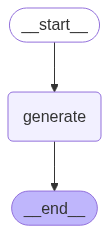

In [13]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### 2. graph invoke 하기

graph를 invoke 하기 위해서는 정의한 State를 인자로 입력해야한다.
앞에서 정의한 `AgentState`는 딕셔너리 형태이고 "messages" 필드가 있으며 이것의 value는 리스트임을 기억하자.

In [14]:
from langchain_core.messages import HumanMessage

query = "인프런에는 어떤 강의가 있나요?"
initial_state = {"messages": [HumanMessage(query)]}

graph.invoke(initial_state)

{'messages': [AIMessage(content='인프런은 다양한 주제의 온라인 강의를 제공하는 플랫폼으로, 주로 IT, 프로그래밍, 데이터 분석, 디자인, 마케팅 등 여러 분야의 강의가 있습니다. 예를 들어, 아래와 같은 강의가 있을 수 있습니다:\n\n1. **프로그래밍 언어**: Python, Java, JavaScript, C++, Ruby 등\n2. **웹 개발**: HTML, CSS, React, Node.js, Django 등\n3. **모바일 개발**: Android, iOS, Flutter 등\n4. **데이터 과학**: 데이터 분석, 머신러닝, 딥러닝, 통계학 등\n5. **디자인**: UX/UI 디자인, 그래픽 디자인, 포토샵, 일러스트레이터 등\n6. **마케팅**: 디지털 마케팅, SEO, 콘텐츠 마케팅 등\n7. **클라우드 및 DevOps**: AWS, Azure, Docker, Kubernetes 등\n\n각 강의는 실제 사례를 기반으로 하거나 프로젝트 중심으로 진행되며, 강사들의 경험을 통해 실용적인 지식을 얻을 수 있습니다. 인프런 홈페이지에서 원하는 주제를 검색하여 구체적인 강의를 찾아보실 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 258, 'prompt_tokens': 18, 'total_tokens': 276, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprin